# Code to analyze neuropixel data across sleep 


Basic definition of exp parameters and query for files


In [85]:
from pinkrigs_tools.dataset.query import load_data, queryCSV
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
import seaborn as sns
from scipy import stats, signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from neuropixel_utils import *
%load_ext autoreload
%autoreload 2

SUBJECT = 'AV049'
EXP_DATE = '2023-07-27'
EXP_NUM = '2'

exp = queryCSV(
    subject=SUBJECT,
    expDate=EXP_DATE,
    expNum=EXP_NUM,
)

# 1. Define experiment parameters once
exp_kwargs = {
    'subject': [SUBJECT],
    'expDate': EXP_DATE,
    'expNum': EXP_NUM,
}


#2. Create an output directory in the DLC folder
dlc_folder = f"C:\\Users\\Experiment\\Projects\\video_conversions\\subjects\{SUBJECT}\{EXP_DATE}_{EXP_NUM}\DLC"
output_folder = os.path.join(dlc_folder, "neuropixel_analysis")
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Output folder created: {output_folder}")

# define the ONE data to load:
data_name_dict = {'events':{'_av_trials':'table'}}
recordings = load_data(data_name_dict=data_name_dict,**exp_kwargs)
exp_info = queryCSV(**exp_kwargs)
print(f"Analysis for: Subject {SUBJECT}, Date {EXP_DATE}, Experiment {EXP_NUM}")
print("Experiment folder:", exp_info['expFolder'].iloc[0])
print("Ephys paths:")
print("- Probe 0:", exp_info['ephysPathProbe0'].iloc[0])
print("- Probe 1:", exp_info['ephysPathProbe1'].iloc[0])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Analysis for: Subject AV049, Date 2023-07-27, Experiment 2
Experiment folder: \\zaru.cortexlab.net\Subjects\AV049\2023-07-27\2
Ephys paths:
- Probe 0: \\zaru.cortexlab.net\Subjects\AV049\2023-07-27\ephys\AV049_2023-07-27_freely-moving_g0\AV049_2023-07-27_freely-moving_g0_imec0
- Probe 1: \\zaru.cortexlab.net\Subjects\AV049\2023-07-27\ephys\AV049_2023-07-27_freely-moving_g0\AV049_2023-07-27_freely-moving_g0_imec1


Load spike data


Processed probe0:
Shape of counts matrix: (798, 24635)
Time bins: 24635 bins from 0.00s to 2463.40s
Number of clusters: 798


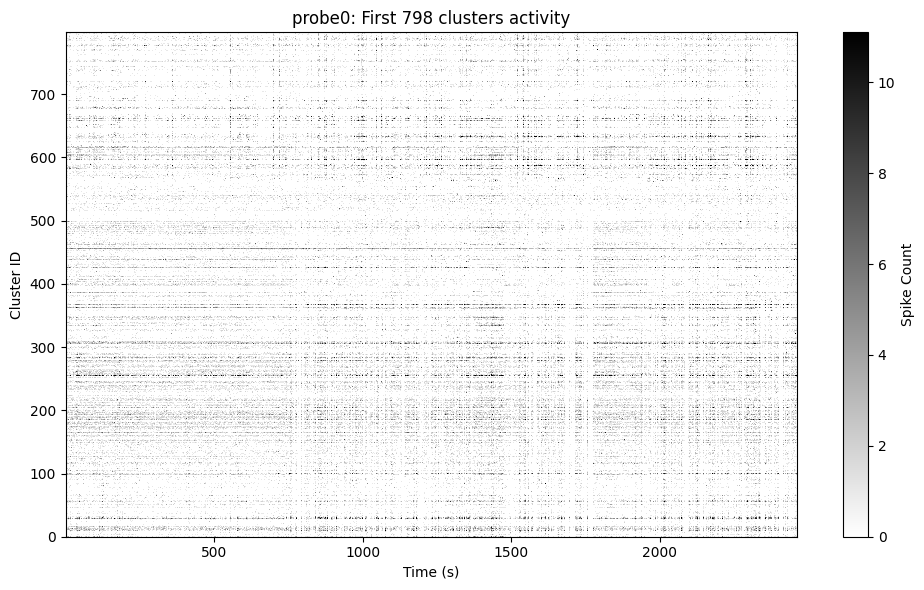


Processed probe1:
Shape of counts matrix: (690, 24635)
Time bins: 24635 bins from 0.00s to 2463.40s
Number of clusters: 690


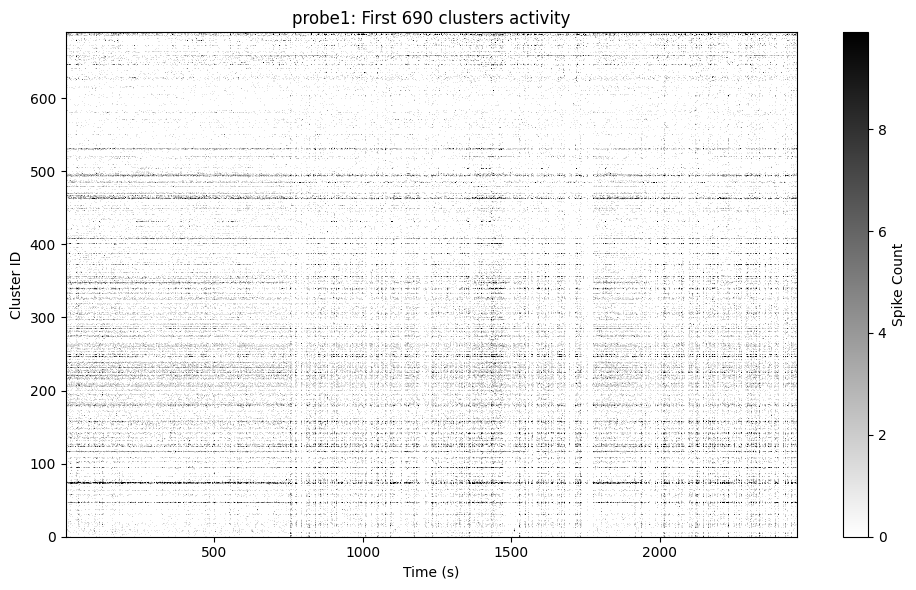


Results for probe0:
Shape of counts matrix: (798, 24635)
Number of time bins: 24635
Number of clusters: 798

Results for probe1:
Shape of counts matrix: (690, 24635)
Number of time bins: 24635
Number of clusters: 690
Available spike data fields for probe 0: ['amps', 'clusters', 'depths', 'templates', 'times', '_av_shankIDs', '_av_xpos']

Available cluster data fields for probe 0: ['amps', 'channels', 'depths', 'peakToTrough', 'waveforms', 'waveformsChannels', '_av_IDs', '_av_KSLabels', 'cluster_id', 'amp_max', 'amp_min', 'amp_median', 'amp_std_dB', 'contamination', 'contamination_alt', 'drift', 'missed_spikes_est', 'noise_cutoff', 'presence_ratio', 'presence_ratio_std', 'slidingRP_viol', 'spike_count', 'firing_rate', 'label', 'ks2_contamination_pct', 'ks2_label', '_av_shankID', '_av_xpos', 'maxChannels', 'phy_clusterID', 'clusterID', 'useTheseTimesStart', 'useTheseTimesStop', 'RPV_tauR_estimate', 'percentageSpikesMissing_gaussian', 'percentageSpikesMissing_symmetric', 'ksTest_pValue',

In [64]:
# Process and bin spike data
results = process_spike_data(
    exp_kwargs=exp_kwargs,
    bin_size=0.1, #
    show_plots=True,
)

# Display summary of the results
for probe in results:
    print(f"\nResults for {probe}:")
    print(f"Shape of counts matrix: {results[probe]['counts'].shape}")
    print(f"Number of time bins: {len(results[probe]['time_bins'])}")
    print(f"Number of clusters: {len(results[probe]['cluster_ids'])}")

# Only load the raw spike recordings when you need them for additional analysis
ephys_dict = {'spikes':'all','clusters':'all'}
data_name_dict = {'probe0':ephys_dict,'probe1':ephys_dict} 
spike_recordings = load_data(data_name_dict=data_name_dict, **exp_kwargs)

# If you want to examine the raw data structure
spike_data_probe0 = spike_recordings['probe0'][0]['spikes']
print("Available spike data fields for probe 0:", list(spike_data_probe0.keys()))
cluster_data_probe0 = spike_recordings['probe0'][0]['clusters']
print("\nAvailable cluster data fields for probe 0:", list(cluster_data_probe0.keys()))

Load camera data

In [65]:
# Load camera data
data_name_dict = {'topCam': {'camera': ['times']}}
camera_recordings = load_data(data_name_dict=data_name_dict, **exp_kwargs)

print("Camera recordings loaded from:", exp_info['expFolder'].iloc[0])
# Access the camera times
if 'topCam' in camera_recordings and not camera_recordings['topCam'].empty:
    topCam_data = camera_recordings['topCam'].iloc[0]
    
    if hasattr(topCam_data, 'camera') and hasattr(topCam_data.camera, 'times'):
        cam_times = topCam_data.camera.times
        
        # Print basic statistics about the camera timestamps
        print(f"Number of camera frames: {len(cam_times)}")
        print(f"First 5 timestamps: {cam_times[:5]}")
        print(f"Last 5 timestamps: {cam_times[-5:]}")
        
        first_time = cam_times[0]
        last_time = cam_times[-1]
        duration = last_time - first_time
        
        print(f"\nFirst timestamp: {first_time:.5f}")
        print(f"Last timestamp: {last_time:.5f}")
        print(f"Duration: {duration:.5f} seconds")
        
        # Calculate average frame rate
        frame_rate = (len(cam_times) - 1) / duration
        print(f"Average frame rate: {frame_rate:.2f} frames per second")
    else:
        print("Error: 'times' attribute not found in camera data")
else:
    print("Error: No topCam data found in the recordings")

Camera recordings loaded from: \\zaru.cortexlab.net\Subjects\AV049\2023-07-27\2
Number of camera frames: 144500
First 5 timestamps: [-8.05320018 -8.03653335 -8.01986652 -8.0031997  -7.98653287]
Last 5 timestamps: [2400.2199261  2400.23659293 2400.25325975 2400.26992658 2400.28659341]

First timestamp: -8.05320
Last timestamp: 2400.28659
Duration: 2408.33979 seconds
Average frame rate: 60.00 frames per second


In [66]:
# Import the bombcell_sort_units function
from pinkrigs_tools.utils.spk_utils import bombcell_sort_units

# Apply Bombcell classification to each probe
for probe in results:
    if probe in spike_recordings and len(spike_recordings[probe]) > 0:
        cluster_data = spike_recordings[probe][0]['clusters']
        cluster_quality = bombcell_sort_units(cluster_data)
        results[probe]['cluster_quality'] = cluster_quality
        results[probe]['good_cluster_mask'] = np.array([q == 'good' for q in cluster_quality])
        results[probe]['good_mua_cluster_mask'] = np.array([q in ['good', 'mua'] for q in cluster_quality])
        
        # Print summary
        unique_qualities, counts = np.unique(cluster_quality, return_counts=True)
        print(f"\nBombcell classification for {probe}:")
        for quality, count in zip(unique_qualities, counts):
            print(f"- {quality}: {count} clusters")
            
        # Add a boolean mask for good clusters to results for easy filtering
        results[probe]['good_cluster_mask'] = np.array([q == 'good' for q in cluster_quality])
        
        print(f"Total clusters: {len(cluster_quality)}")
        print(f"Good+MUA clusters: {np.sum(results[probe]['good_mua_cluster_mask'])} ({np.sum(results[probe]['good_mua_cluster_mask'])/len(cluster_quality)*100:.1f}%)")



Bombcell classification for probe0:
- good: 204 clusters
- mua: 183 clusters
- noise: 411 clusters
Total clusters: 798
Good+MUA clusters: 387 (48.5%)

Bombcell classification for probe1:
- good: 151 clusters
- mua: 203 clusters
- noise: 336 clusters
Total clusters: 690
Good+MUA clusters: 354 (51.3%)


## Select Sleep Periods based on Power Bands 

Provides moving average and Savitzky-Golay filtering; select one to be saved to "sleep_times.csv" in the neuropixel output folder. 

In [67]:
freq_results = process_spike_data(
    exp_kwargs=exp_kwargs,
    bin_size=0.005,  # 200Hz sampling rate
    show_plots=False  
)


# Apply Bombcell classification to each probe
for probe in freq_results:
    if probe in spike_recordings and len(spike_recordings[probe]) > 0:
        cluster_data = spike_recordings[probe][0]['clusters']
        cluster_quality = bombcell_sort_units(cluster_data)
        freq_results[probe]['cluster_quality'] = cluster_quality
        freq_results[probe]['good_cluster_mask'] = np.array([q == 'good' for q in cluster_quality])
        freq_results[probe]['good_mua_cluster_mask'] = np.array([q in ['good', 'mua'] for q in cluster_quality])
        unique_qualities, counts = np.unique(cluster_quality, return_counts=True)
        print(f"\nBombcell classification for {probe}:")
        for quality, count in zip(unique_qualities, counts):
            print(f"- {quality}: {count} clusters")
            
        print(f"Total clusters: {len(cluster_quality)}")
        print(f"Good+MUA clusters: {np.sum(freq_results[probe]['good_mua_cluster_mask'])} ({np.sum(freq_results[probe]['good_mua_cluster_mask'])/len(cluster_quality)*100:.1f}%)")



Processed probe0:
Shape of counts matrix: (798, 492672)
Time bins: 492672 bins from 0.00s to 2463.36s
Number of clusters: 798

Processed probe1:
Shape of counts matrix: (690, 492673)
Time bins: 492673 bins from 0.00s to 2463.36s
Number of clusters: 690

Bombcell classification for probe0:
- good: 204 clusters
- mua: 183 clusters
- noise: 411 clusters
Total clusters: 798
Good+MUA clusters: 387 (48.5%)

Bombcell classification for probe1:
- good: 151 clusters
- mua: 203 clusters
- noise: 336 clusters
Total clusters: 690
Good+MUA clusters: 354 (51.3%)


In [68]:
spectrum_results = analyze_power_spectrum(
    results=freq_results,
    output_dir=output_folder,
    save_plots=False,
    show_plots=False,
    nperseg=200,
    noverlap=150,
    freq_range=(0, 50), 
    sleep_bouts=None,
    use_quality_filter=True,
)

Sampling rate: 200.0Hz (bin_size=0.0050s)
Maximum detectable frequency: 100.0Hz
Filtered probe0: kept 387 of 798 clusters
Probe probe0: Selected 387 clusters ('good' and 'mua') out of 798
Filtered probe1: kept 354 of 690 clusters
Probe probe1: Selected 354 clusters ('good' and 'mua') out of 690
Merged 741 clusters from 2 probes
Using 492672 time bins (truncated to match across probes)


Loaded 17 behavioral sleep bouts for comparison
Time step: 0.24997s, minimum sleep duration: 10s (40 samples)

Behavioral Sleep Statistics:
- 17 sleep bouts
- Total sleep time: 1309.3s (53.2% of recording)

Moving Average Sleep Detection (threshold=-48dB, min duration=10s):
- Detected 10 sleep bouts
- Total sleep time: 1252.8s (50.9% of recording)
- Comparison to behavioral sleep:
  * Precision: 0.90 (proportion of detected sleep that matches behavior)
  * Recall: 0.86 (proportion of behavioral sleep that was detected)
  * IoU: 0.78 (Intersection over Union)

Savitzky-Golay Sleep Detection (threshold=-49dB, min duration=10s):
- Detected 12 sleep bouts
- Total sleep time: 1280.5s (52.0% of recording)
- Comparison to behavioral sleep:
  * Precision: 0.88 (proportion of detected sleep that matches behavior)
  * Recall: 0.86 (proportion of behavioral sleep that was detected)
  * IoU: 0.77 (Intersection over Union)


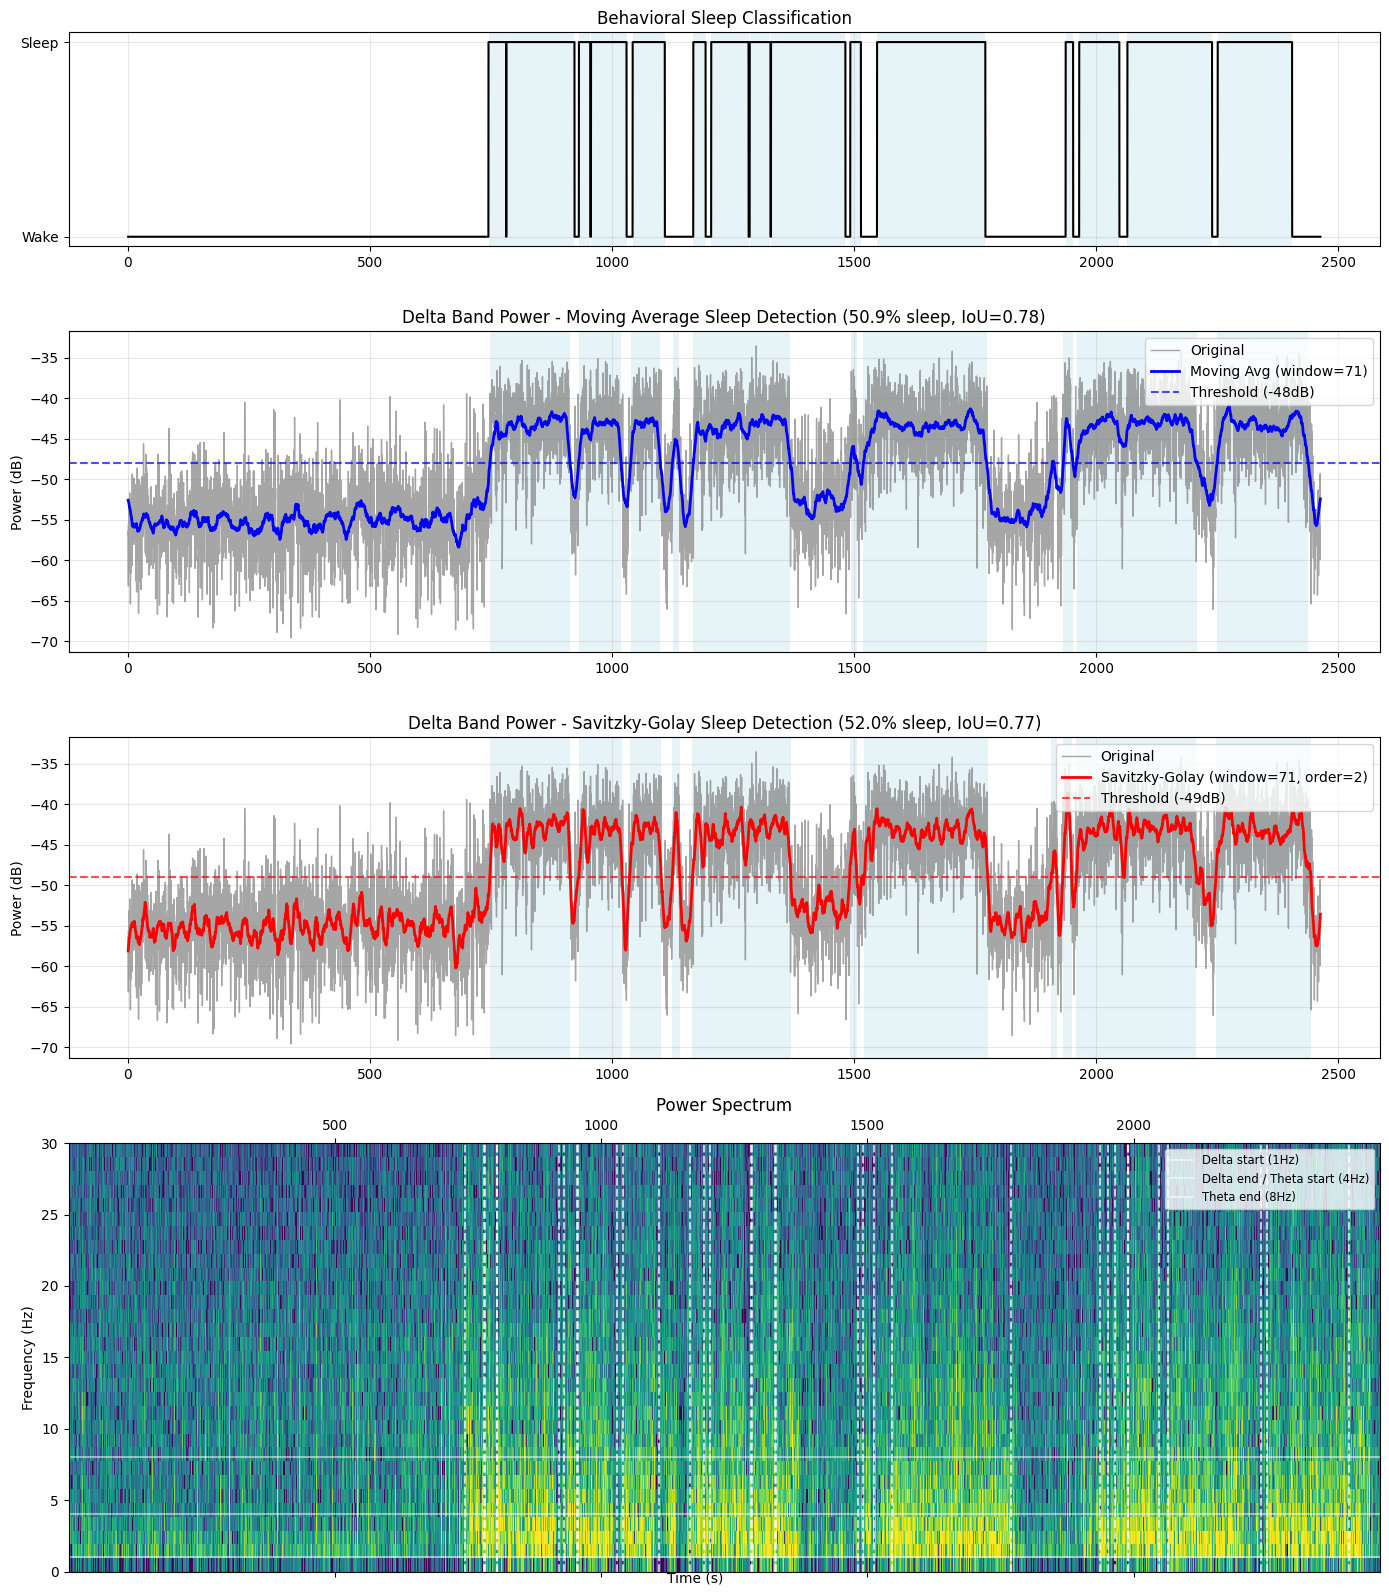

Moving Average Sleep Periods:
   start_time  end_time  duration          method
0      747.50    913.00    165.50  Moving Average
1      930.75   1018.50     87.75  Moving Average
2     1038.25   1099.50     61.25  Moving Average
3     1124.75   1138.25     13.50  Moving Average
4     1167.75   1367.75    200.00  Moving Average
5     1492.50   1506.25     13.75  Moving Average
6     1518.75   1773.50    254.75  Moving Average
7     1932.00   1951.25     19.25  Moving Average
8     1959.25   2208.00    248.75  Moving Average
9     2249.50   2437.75    188.25  Moving Average

Savitzky-Golay Sleep Periods:
    start_time  end_time  duration          method
0       747.50    913.75    166.25  Savitzky-Golay
1       931.00   1020.50     89.50  Savitzky-Golay
2      1036.25   1101.25     65.00  Savitzky-Golay
3      1124.50   1139.50     15.00  Savitzky-Golay
4      1166.00   1369.00    203.00  Savitzky-Golay
5      1490.50   1505.00     14.50  Savitzky-Golay
6      1520.50   1775.50    255.

In [12]:
beh_sleep_csv = os.path.join(dlc_folder, r"pixel_difference\sleep_times.csv")
if os.path.exists(beh_sleep_csv):
    beh_df_sleep = pd.read_csv(beh_sleep_csv)
    if beh_df_sleep.shape[0] == 0:
        print("Warning: Behavioral sleep CSV exists but contains no sleep bouts")
        beh_df_sleep = None
    else:
        print(f"Loaded {len(beh_df_sleep)} behavioral sleep bouts for comparison")
        if 'start_time_s' in beh_df_sleep.columns and 'end_time_s' in beh_df_sleep.columns:
            beh_df_sleep = beh_df_sleep.rename(columns={
                'start_time_s': 'start_timestamp_s',
                'end_time_s': 'end_timestamp_s'
        })
    
smoothed_results = power_band_smoothing(
    spectrum_results=spectrum_results,
    window_size=71,
    poly_order=2,
    threshold_ma=-48,
    threshold_sg=-49,
    min_duration_s=10,
    output_dir=output_folder,
    df_sleep=beh_df_sleep,
    save_plots=False, 
)

print("Moving Average Sleep Periods:")
print(smoothed_results['sleep_df_ma'])

print("\nSavitzky-Golay Sleep Periods:")
print(smoothed_results['sleep_df_sg'])

In [13]:
neural_sleep_csv = save_sleep_periods_to_csv(
    smoothed_results=smoothed_results, 
    output_dir=output_folder,
    used_filter='SG', # or 'MA' for moving average
    frame_rate=60
)

df_neural_sleep = pd.read_csv(neural_sleep_csv)


Saved detected sleep periods to: C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-07-27_2\DLC\neuropixel_analysis\sleep_times.csv
Total sleep periods: 12
Total sleep time: 1280.5 seconds
Frames calculated using frame rate of 60 fps
Frame range: 44851-146581


Align sleep data to the camera data and add timestamps to the csv file. 

In [69]:
results = map_sleep_bouts_to_neural_data(results, neural_sleep_csv, cam_times)
freq_results = map_sleep_bouts_to_neural_data(freq_results, neural_sleep_csv, cam_times)


Alignment information for probe0:
- Camera time range: -8.05s to 2400.29s
- Neural time range: 0.00s to 2463.40s
- Automatic time offset: 8.05s
  (Adding 8.05s to camera timestamps to align with neural data)

Sleep bout mapping for probe0:
- Time bins range: 0.00s to 2463.40s
- Bin size: 0.10s
- Total bins: 24635
- Number of sleep bouts: 12
- Sleep bouts within neural recording range: 12

Sample mapping (first 5 bouts):
   start_timestamp_s  aligned_start_timestamp_s  start_bin_time  \
0             747.50                   755.5532      755.600133   
1             931.00                   939.0532      939.100133   
2            1036.25                  1044.3032     1044.300133   
3            1124.50                  1132.5532     1132.600133   
4            1166.00                  1174.0532     1174.100133   

   end_timestamp_s  aligned_end_timestamp_s  end_bin_time  duration_s  \
0           913.75                 921.8032    921.800133      166.25   
1          1020.50        

Filter clusters by "good" and "mua" based on bombcell sorting and plot:

    1. The average firing rate of all units across the recording with sleep times highlighted
    2. The average activity of the 10 clusters with highest difference between average firing in sleep periods - average firing in wake periods (highest/lowest 10 clusters shown)


Filtered probe0: kept 387 of 798 clusters
Filtered probe1: kept 354 of 690 clusters

Results for merged probes:

Top 10 sleep-selective clusters:
  1. probe0 Cluster 466: Modulation = -0.8346 (Sleep: 0.3004 Hz, Wake: 0.0271 Hz)
  2. probe0 Cluster 443: Modulation = -0.8205 (Sleep: 0.2317 Hz, Wake: 0.0228 Hz)
  3. probe0 Cluster 323: Modulation = -0.8162 (Sleep: 0.2341 Hz, Wake: 0.0237 Hz)
  4. probe1 Cluster 396: Modulation = -0.7869 (Sleep: 0.7803 Hz, Wake: 0.0931 Hz)
  5. probe0 Cluster 91: Modulation = -0.7671 (Sleep: 0.2247 Hz, Wake: 0.0296 Hz)
  6. probe0 Cluster 404: Modulation = -0.7660 (Sleep: 0.2107 Hz, Wake: 0.0279 Hz)
  7. probe0 Cluster 70: Modulation = -0.7613 (Sleep: 0.1248 Hz, Wake: 0.0169 Hz)
  8. probe0 Cluster 74: Modulation = -0.7510 (Sleep: 0.1904 Hz, Wake: 0.0271 Hz)
  9. probe0 Cluster 414: Modulation = -0.7433 (Sleep: 0.6320 Hz, Wake: 0.0931 Hz)
  10. probe0 Cluster 75: Modulation = -0.7111 (Sleep: 0.5462 Hz, Wake: 0.0922 Hz)

Top 10 wake-selective clusters:
  1.

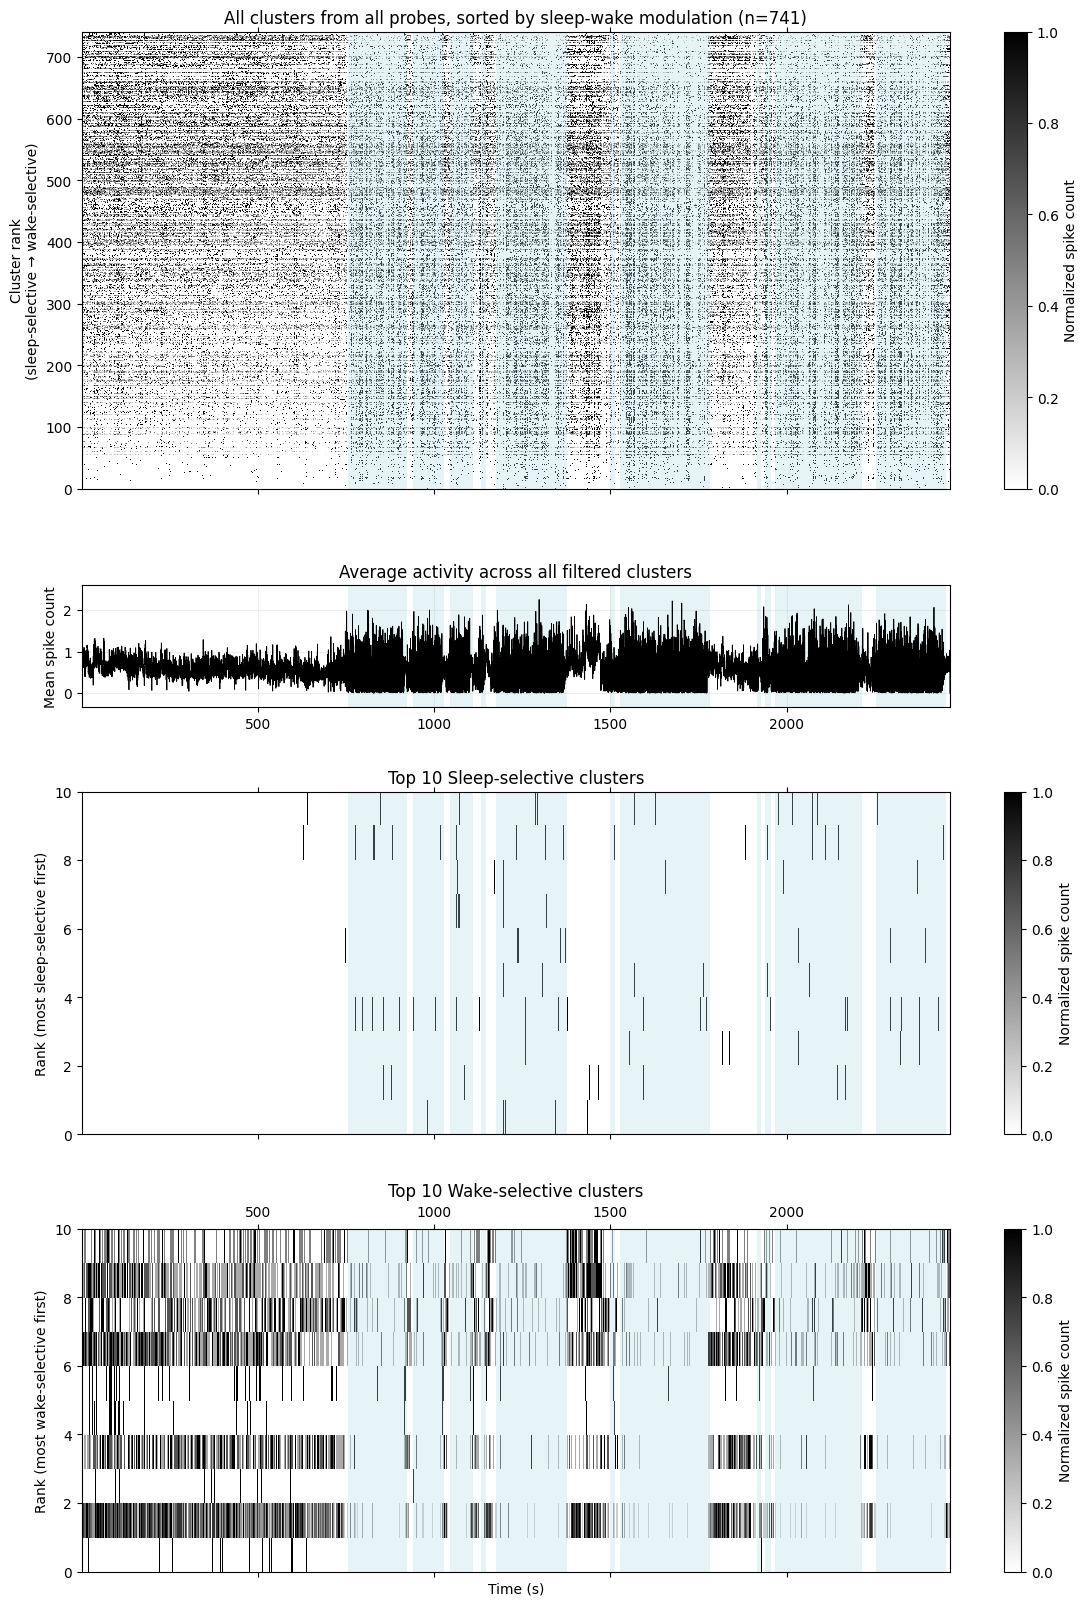

In [70]:
np_results = analyze_sleep_wake_activity(
    results=results,
    output_dir=output_folder,
    save_plots=True,
    num_top_clusters=10
)

Looking at the frequency across the recording

Loaded behavioral data from C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-07-27_2\DLC\pixel_difference\2023-07-27_2_AV049_topCam_pixel_differences.csv
Filtered probe0: kept 387 of 798 clusters
Filtered probe1: kept 354 of 690 clusters
Filtered probe0: kept 387 of 798 clusters
Filtered probe1: kept 354 of 690 clusters
Using Savitzky-Golay filter for frequency band visualization
Saved combined plot to: C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-07-27_2\DLC\neuropixel_analysis\combined_sleep_wake_spectrum_analysis_20250603_134501.png


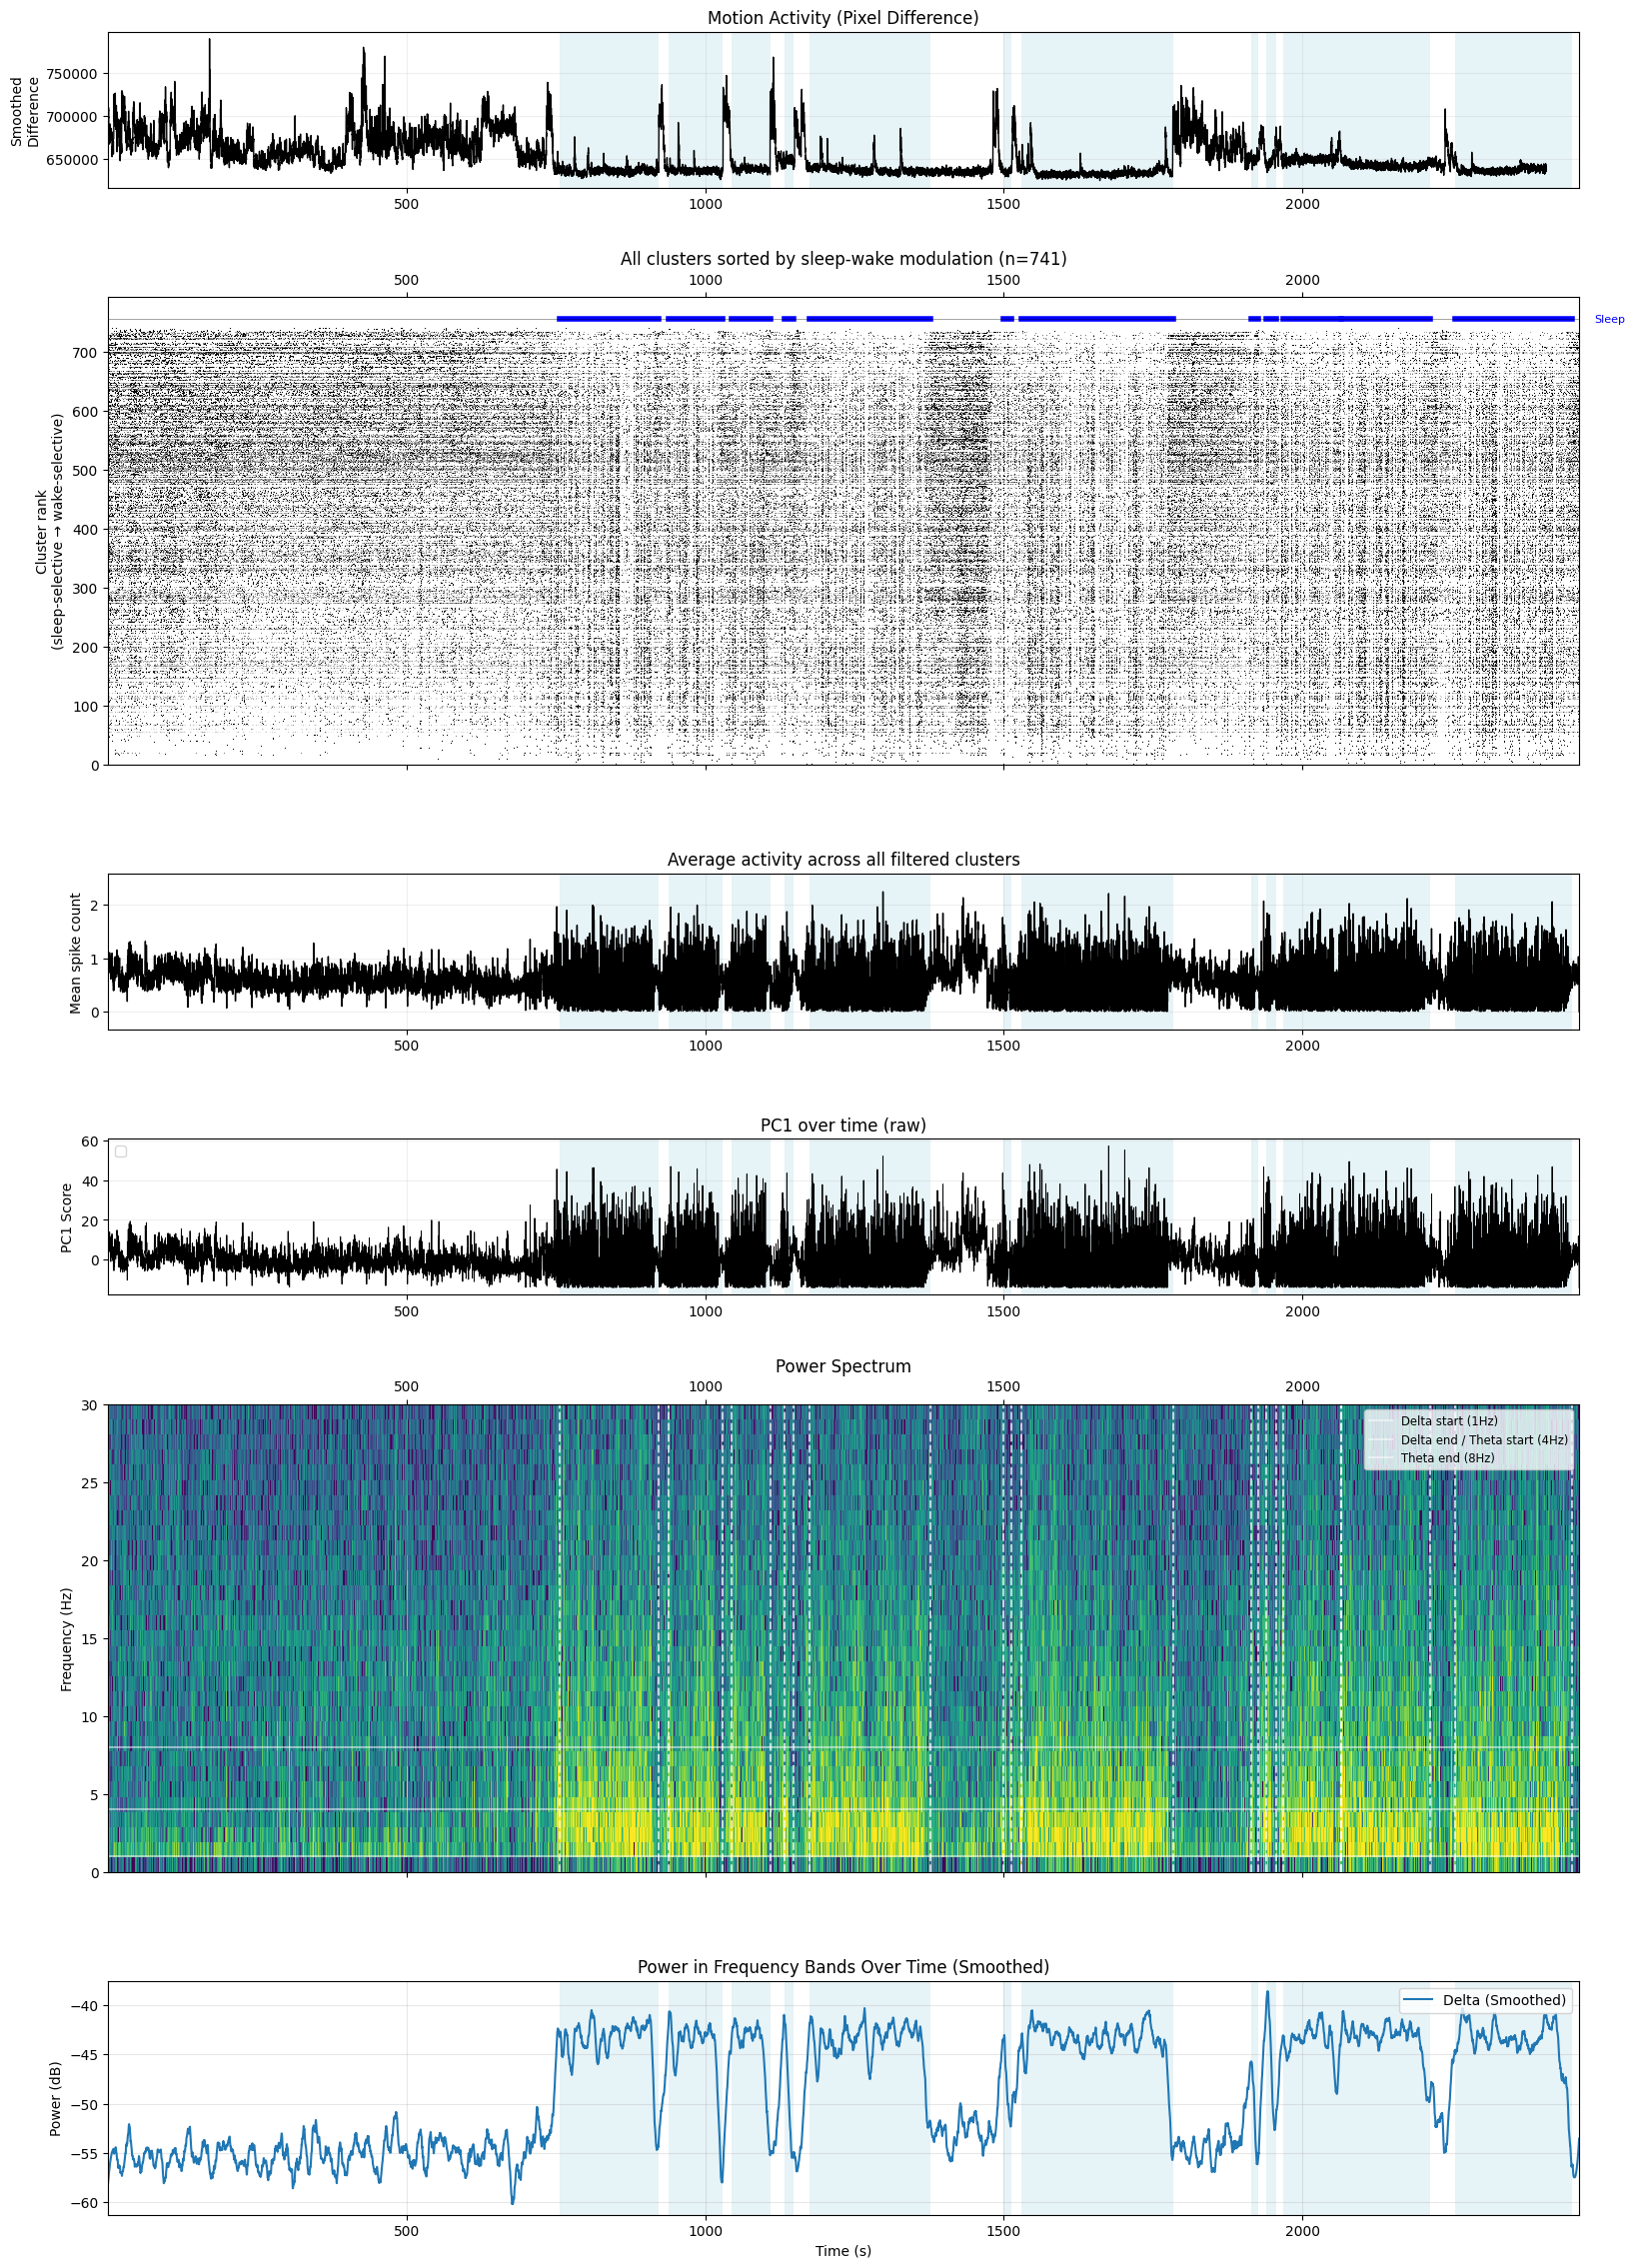

In [78]:
combined_visualization(
    results=results,
    freq_results=freq_results,
    np_results=np_results,
    spectrum_results=spectrum_results,
    dlc_folder=dlc_folder,
    output_dir=output_folder,
    save_plots=True,
    smoothed_results=smoothed_results,
    pca_results=pca_results
)

Save the 200Hz cluster data into a npy file for rastermap - pooled all "good" & "mua" clusters across both probes

In [32]:
low_res_file = combine_neural_data(results, output_folder, SUBJECT, EXP_DATE, EXP_NUM, bin_type='low_res')
high_res_file = combine_neural_data(freq_results, output_folder, SUBJECT, EXP_DATE, EXP_NUM, bin_type='high_res')

Saved combined matrix with shape (741, 24635) to C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-07-27_2\DLC\neuropixel_analysis\AV049_2023-07-27_2_combined_neural_low_res.npy
Saved combined matrix with shape (741, 492672) to C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-07-27_2\DLC\neuropixel_analysis\AV049_2023-07-27_2_combined_neural_high_res.npy


## PCA / UMAP analysis

Loaded matrix with shape (741, 24635)
State labels assigned: 11829 wake, 12806 sleep
Shape of data for PCA: (24635, 741)


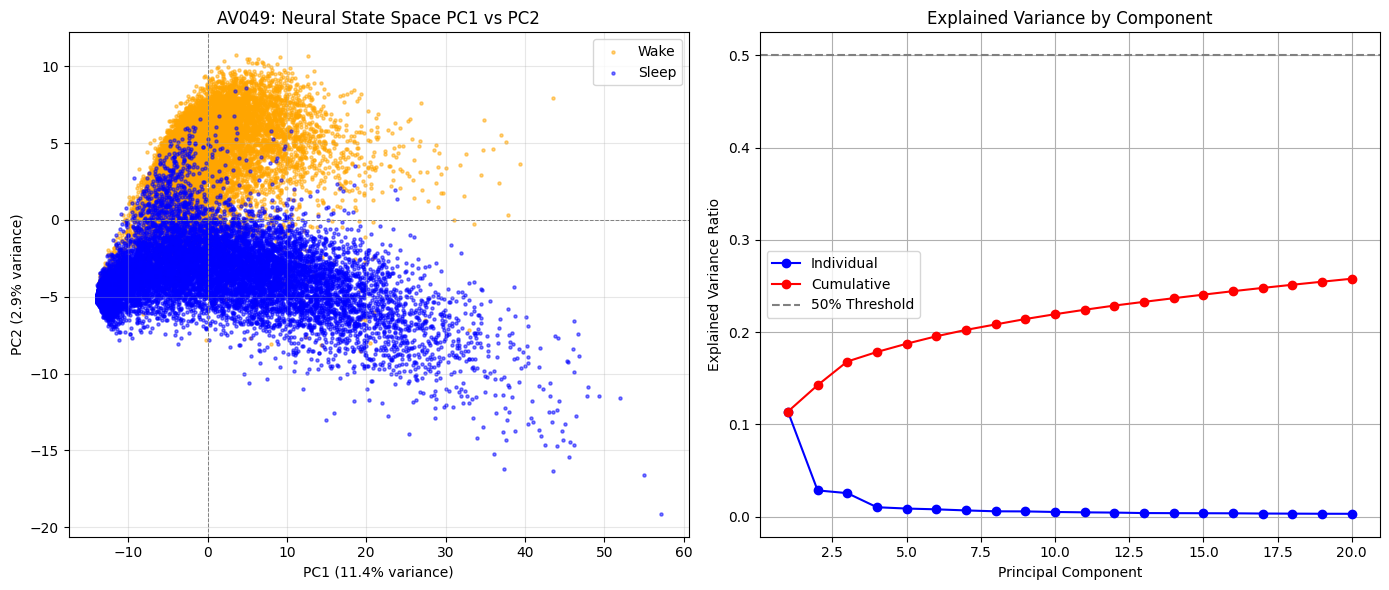

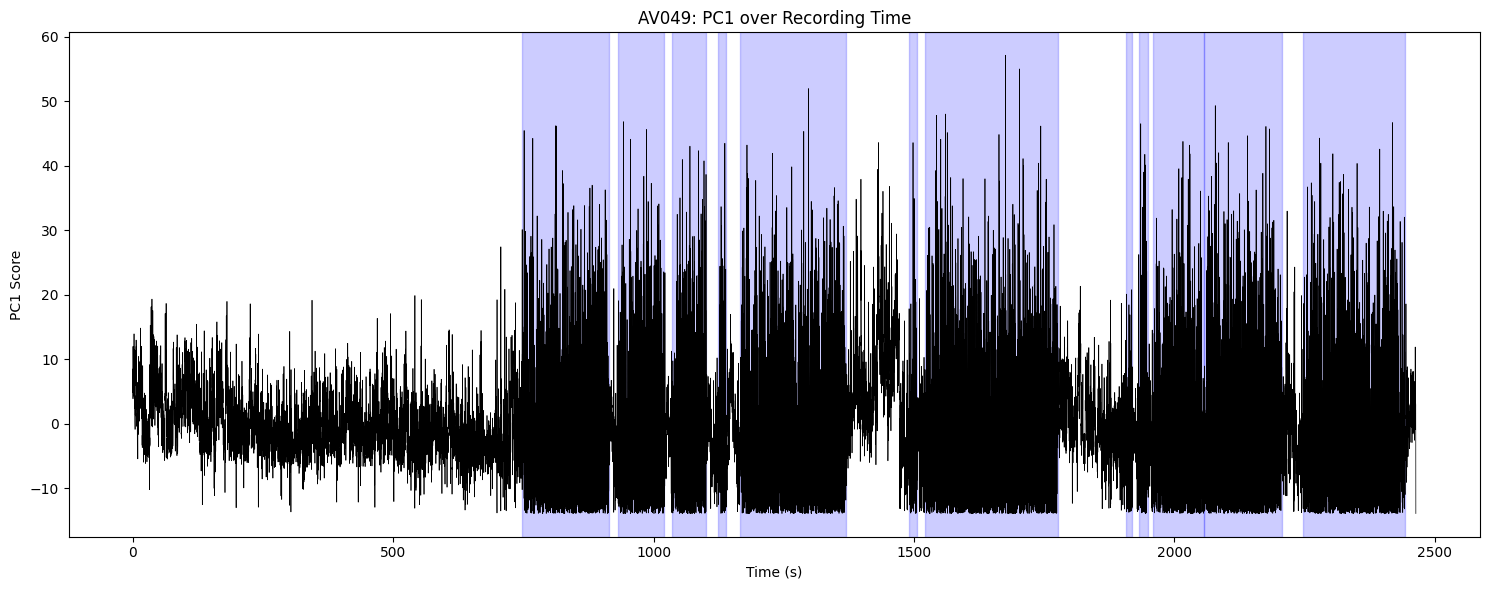

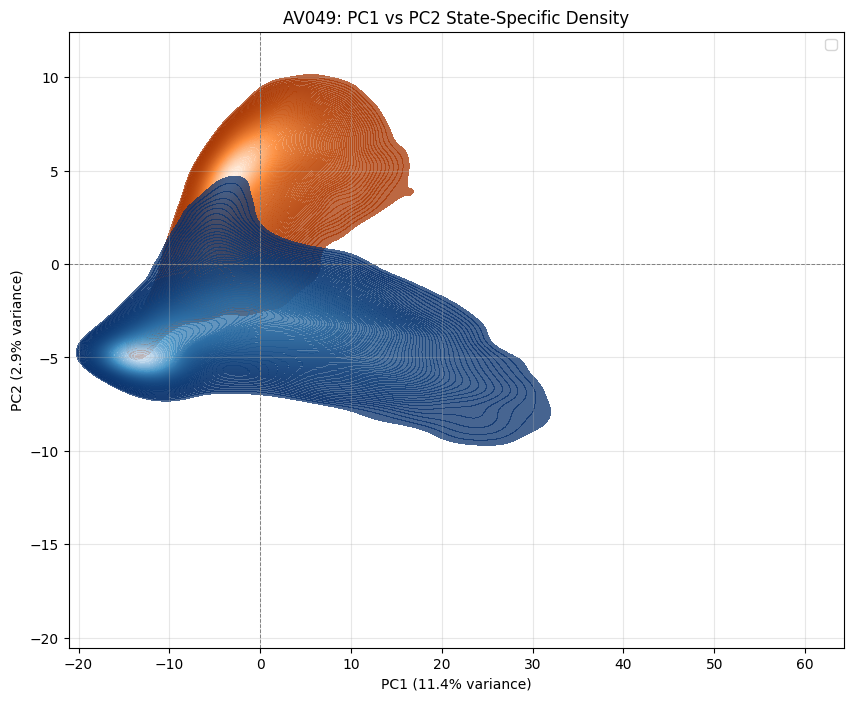

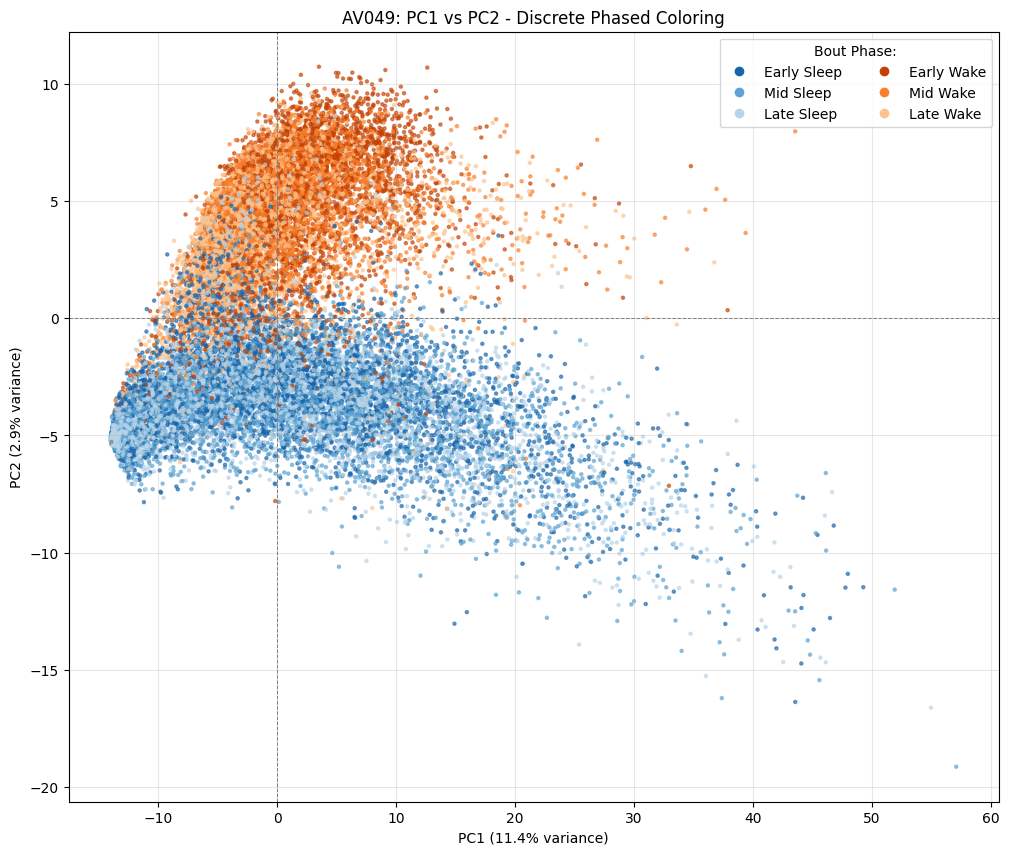

Components needed for 50% variance: 20
Components needed for 70% variance: 20
Components needed for 90% variance: 20


In [110]:
# Select what binning to use by either calling the low_res_file or high_res_file
combined_matrix = np.load(low_res_file)
print(f"Loaded matrix with shape {combined_matrix.shape}")

# Initialize state labels
state_labels = np.zeros(combined_matrix.shape[1])
time_bins = results['probe0']['time_bins']

# Set time points where the state is 'sleep' to 1
for _, row in df_neural_sleep.iterrows():
    start_idx = np.searchsorted(time_bins, row['start_timestamp_s'])
    end_idx = np.searchsorted(time_bins, row['end_timestamp_s'])
    if start_idx < len(state_labels) and end_idx <= len(state_labels):
        state_labels[start_idx:end_idx] = 1
        
print(f"State labels assigned: {np.sum(state_labels == 0)} wake, {np.sum(state_labels == 1)} sleep")

# Run the PCA analysis
pca_results = analyze_neural_pca(
    combined_matrix=combined_matrix,
    state_labels=state_labels,
    time_bins=time_bins,
    neural_sleep_df=df_neural_sleep,
    subject=SUBJECT,
    output_folder=output_folder,
    n_components=20,           # Compute 20 components
    components_to_plot=(0, 1), # Plot PC1 vs PC2
    downsample_factor=1,         # No downsampling for PCA
    pc_index_to_plot=0
)

PC1 data length: 24635
Time bins length: 24635
State labels length: 24635
Window 10: PC1 original length: 24635, smoothed length: 24635
Window 10: Original STD=9.191, Smoothed STD=4.362, Reduction=52.5%
Window 20: PC1 original length: 24635, smoothed length: 24635
Window 20: Original STD=9.191, Smoothed STD=3.863, Reduction=58.0%
Window 40: PC1 original length: 24635, smoothed length: 24635
Window 40: Original STD=9.191, Smoothed STD=3.435, Reduction=62.6%
Window 60: PC1 original length: 24635, smoothed length: 24635
Window 60: Original STD=9.191, Smoothed STD=3.201, Reduction=65.2%


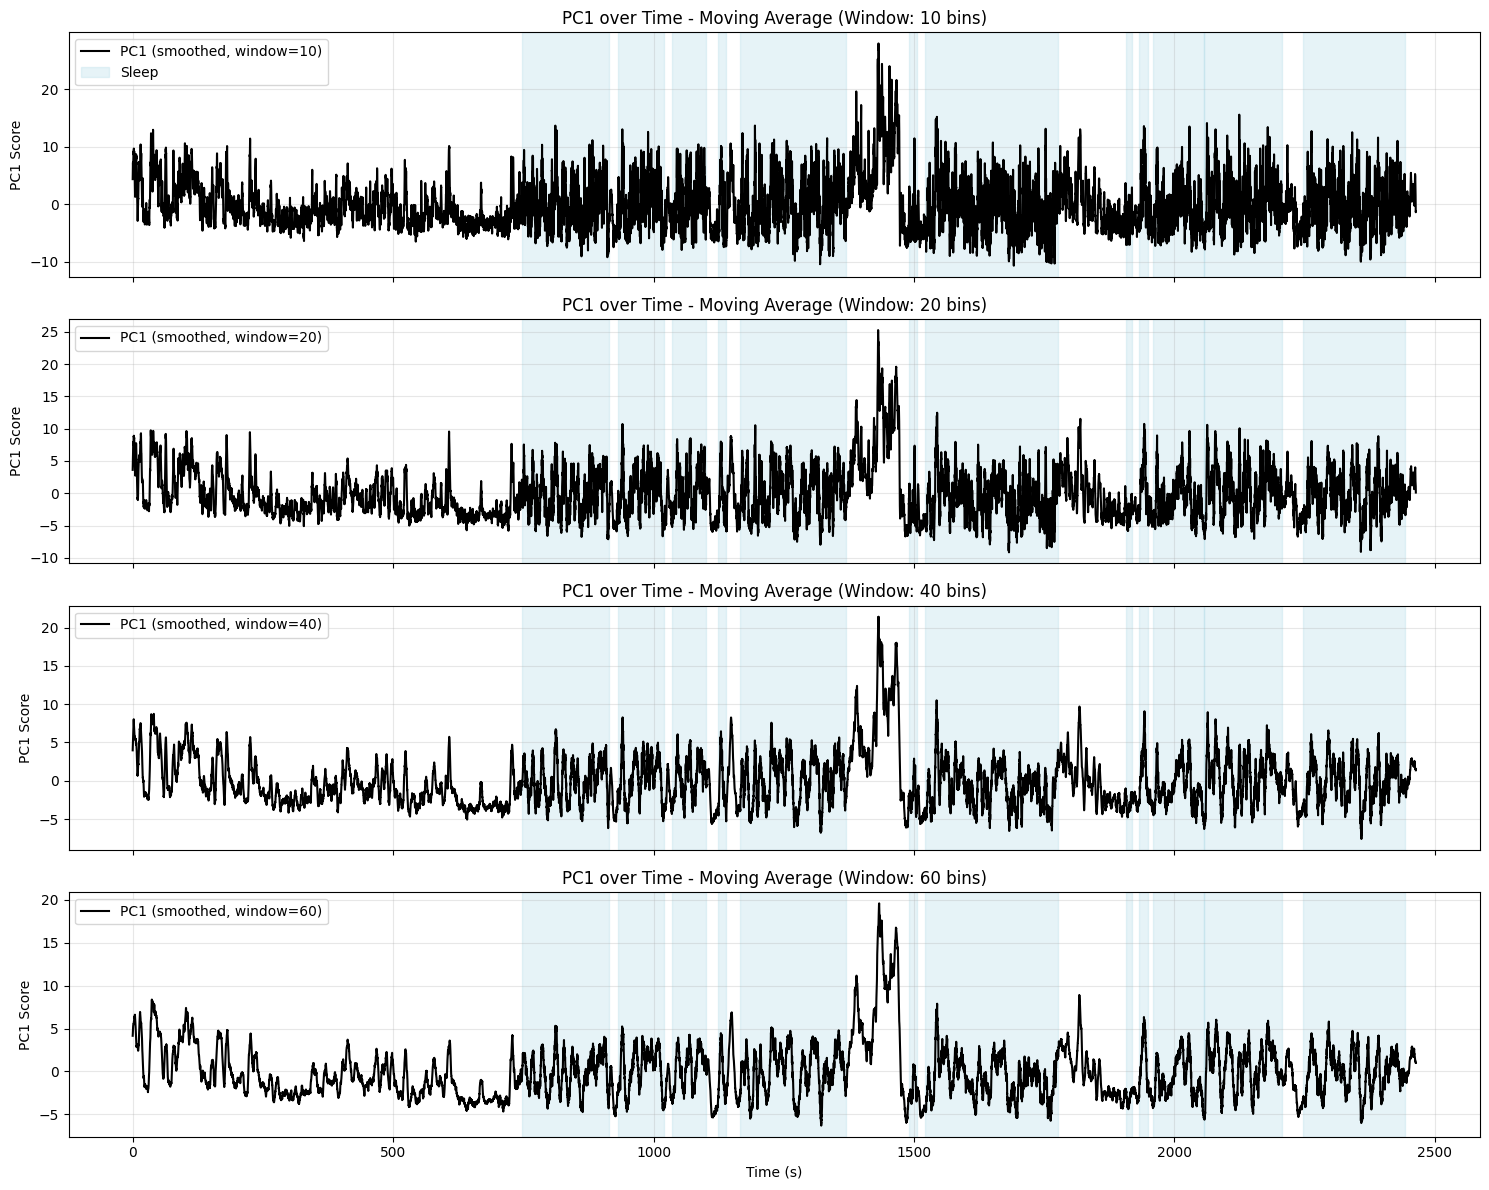

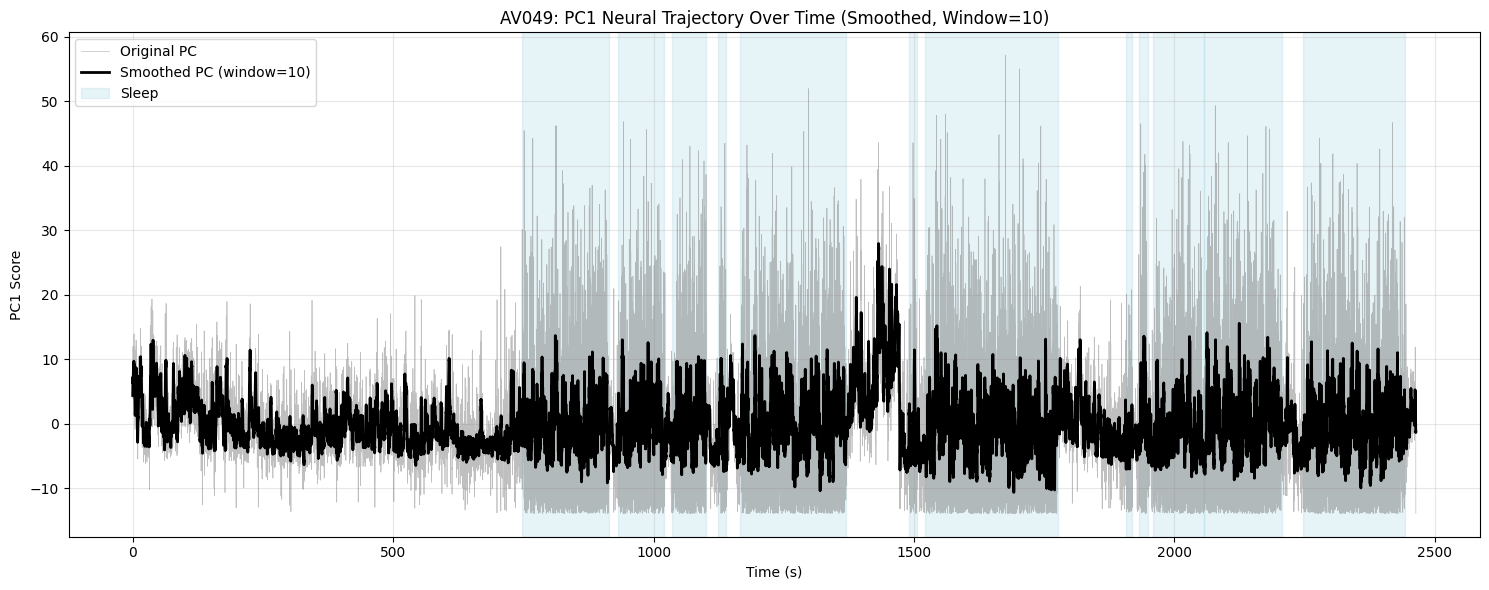

In [91]:
# Try different smoothing for PC over time using moving average
pc_smoothing_results = analyze_pc_smoothing(
    pca_results=pca_results,
    df_neural_sleep=df_neural_sleep,
    subject=SUBJECT,
    output_folder=output_folder,
    window_sizes=[10, 20, 40, 60], # use 4 windows sizes for comparison
    comparison_window=10, # select the window size for comparison to raw PC data
    pc_index_to_plot=0 # Plot PC, 0 = PC1, 1 = PC2 etc.
)

PC Spectrogram: Sampling frequency (fs): 10.00 Hz
PC Spectrogram parameters: nperseg=50 (5.0s), noverlap=25 (2.5s)
PC2 spectrogram saved to C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-07-27_2\DLC\neuropixel_analysis\AV049_pc2_spectrogram.png


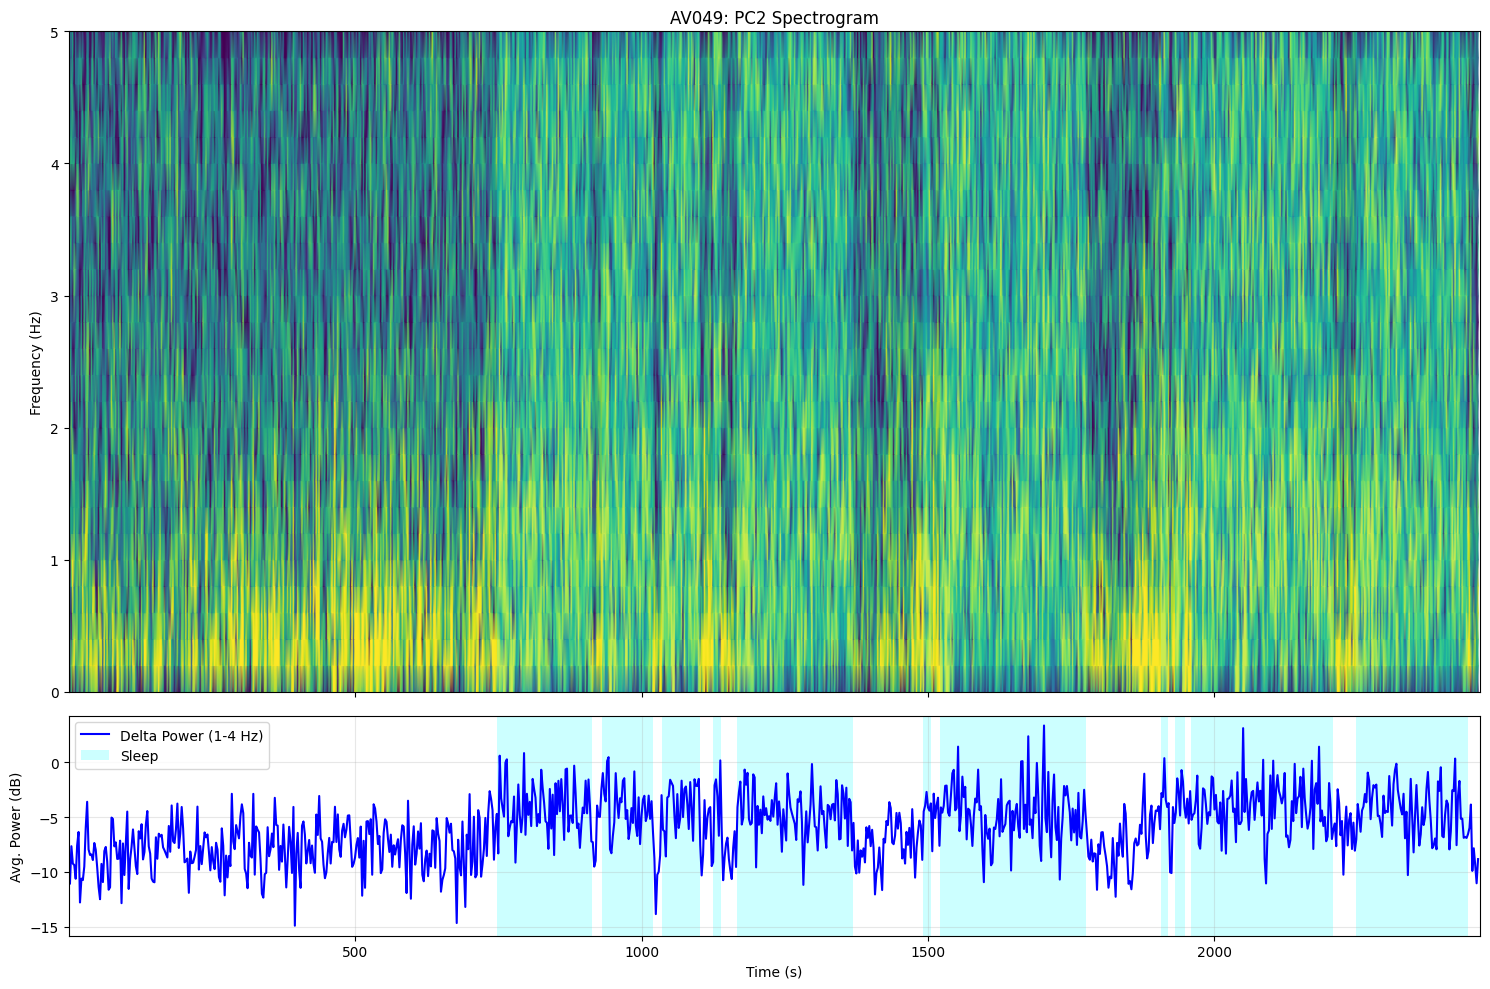

In [98]:
# Look for oscillatory activity in the PC trajectory
index_to_analyze = 1 # PC index to analyze, e.g. 0 for PC1, 1 for PC2, etc.

# Check if pca_results exists and contains the necessary data
if 'pca_results' in globals() and \
   isinstance(pca_results, dict) and \
   'pca_result' in pca_results and \
   'time_bins_used' in pca_results and \
   'df_neural_sleep' in globals() and \
   'SUBJECT' in globals() and \
   'output_folder' in globals():

    # Extract the specific PC data and time bins using index_to_analyze
    all_pc_data = pca_results['pca_result']
    if index_to_analyze < all_pc_data.shape[1]:
        selected_pc_data = all_pc_data[:, index_to_analyze]
        time_bins_for_spectrogram = pca_results['time_bins_used']

        plot_pc_spectrogram(
            pc_data=selected_pc_data,
            time_bins_pca=time_bins_for_spectrogram,
            df_neural_sleep=df_neural_sleep,
            subject_name=SUBJECT,
            output_dir=output_folder,
            nperseg_pc=50,
            noverlap_ratio=0.5,
            save_plots=True,
            show_plots=True,
            pc_index_to_plot=index_to_analyze
        )
    else:
        print(f"Error: index_to_analyze ({index_to_analyze}) is out of bounds for the number of PCs available ({all_pc_data.shape[1]}).")
else:
    print("Error: Required variables (pca_results with 'pca_result' and 'time_bins_used', df_neural_sleep, SUBJECT, output_folder) not found. Please run the PCA analysis cell (d0971f70) first.")


## Quality control metrics 

Bin the entire recording (standard: 120s bins) and sort them into sleep/wake based of majority of state in each bin (standard: 90% of one state as cutoff)


Filtered probe0: kept 387 of 798 clusters
Filtered probe1: kept 354 of 690 clusters

First few rows of DataFrame for merged probes:
     cluster_id  state  firing_rate
0  (probe0, 22)  Sleep     0.179063
1  (probe0, 22)   Wake     0.113690
2  (probe0, 27)  Sleep     0.083542
3  (probe0, 27)   Wake     0.396310
4  (probe0, 32)  Sleep     0.092917
Saved plot to: C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-07-27_2\DLC\neuropixel_analysis\merged_probes_state_firing_rates_20250603_120331.png

Results for merged probes using 120s bins and 90.0% state threshold:
Total large bins: 20
Sleep bins: 4
Wake bins: 7
Mixed bins: 9
Total clusters analyzed: 741

Normalized firing rate statistics:
Sleep: median=0.1770, mean=0.1799
Wake: median=0.1780, mean=0.1940
Mann-Whitney U test: p=0.6913


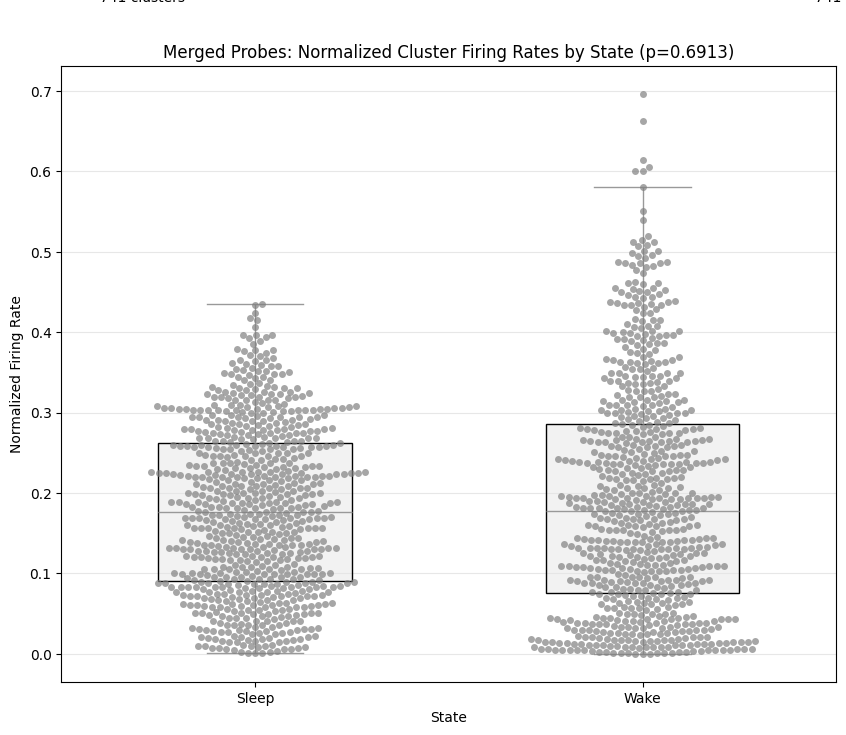

In [58]:
state_results = analyze_cluster_state_distribution(
    results=results,
    output_dir=output_folder,
    save_plots=True,
    bin_size_s=120,
    state_threshold=90
)

Determine stability of clusters across recording
    
    Split the data into C1 and C2, semi-controlled random shuffling (random shuffle until each category has bins from both recording halves (at least 30%) and, if possible, sleep and wake data).

    1. Plot the average firing rate of each cluster in C2 vs C1
    2. Plot the average firing rate of wake-sleep in C2 vs C1


Filtered probe0: kept 387 of 798 clusters
Filtered probe1: kept 354 of 690 clusters

Bin distribution for merged probes:
First half sleep bins: 0
First half wake bins: 6
Second half sleep bins: 4
Second half wake bins: 1
Found balanced split after 3 iterations (0.00s)

Final bin distribution:
C1: 5 bins total, 2 sleep, 3 wake
C2: 15 bins total, 2 sleep, 4 wake

Modulation quadrant counts:
Q1 (Wake selective in both): 299
Q2 (Sleep in C1, Wake in C2): 66
Q3 (Sleep selective in both): 347
Q4 (Wake in C1, Sleep in C2): 28
Saved plot to: C:\Users\Experiment\Projects\video_conversions\subjects\AV049\2023-07-27_2\DLC\neuropixel_analysis\merged_probes_neuronal_stability_20250603_120402.png


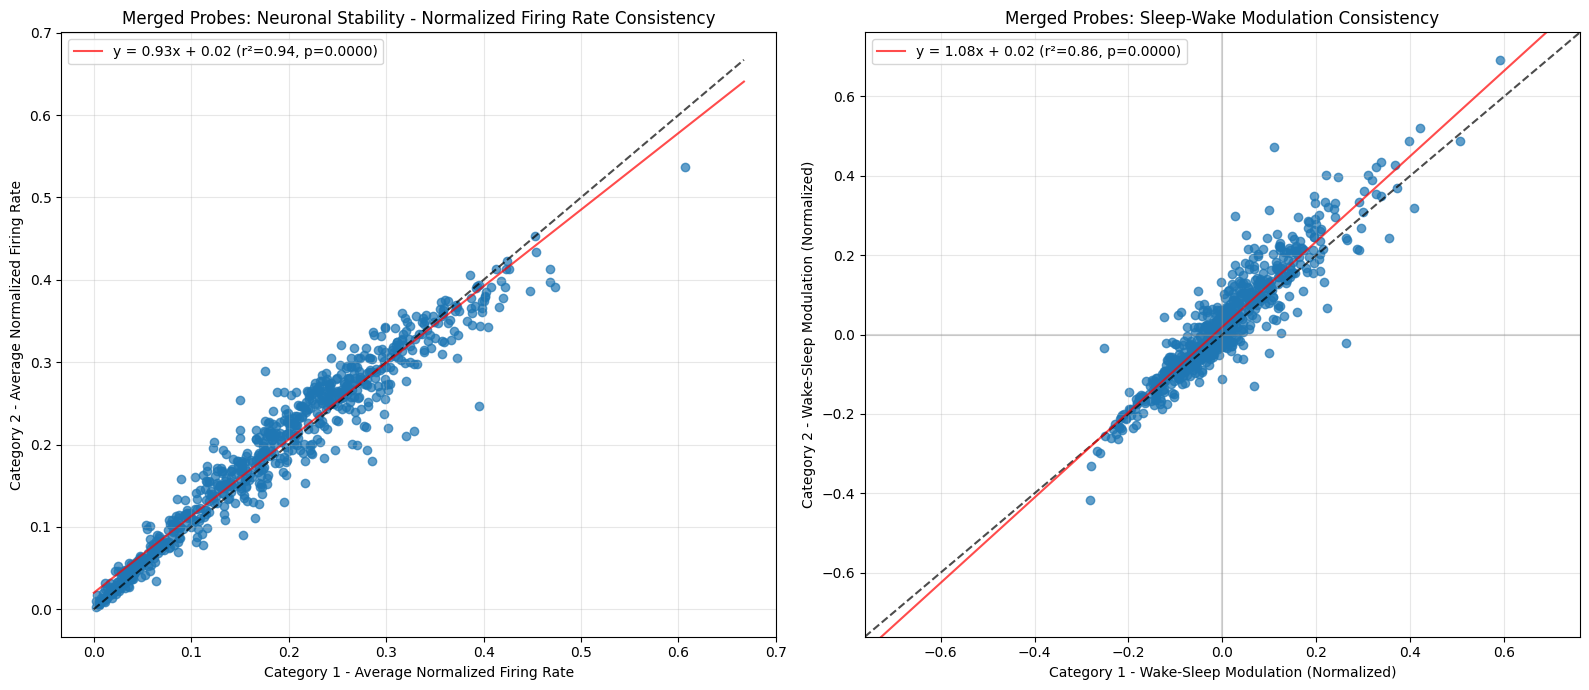


Stability metrics for merged probes:
Total clusters analyzed: 741
Normalized firing rate correlation: r = 0.9713, p = 0.0000
Modulation correlation: r = 0.9249, p = 0.0000
Neurons with consistent sleep/wake preference: 87.2%


In [60]:
stability_results = analyze_neuronal_stability(
    results=results,
    output_dir=output_folder,
    save_plots=True,
    bin_size_s=120,
    state_threshold=90,
    max_iterations=100
)

## Testing (deleted later)


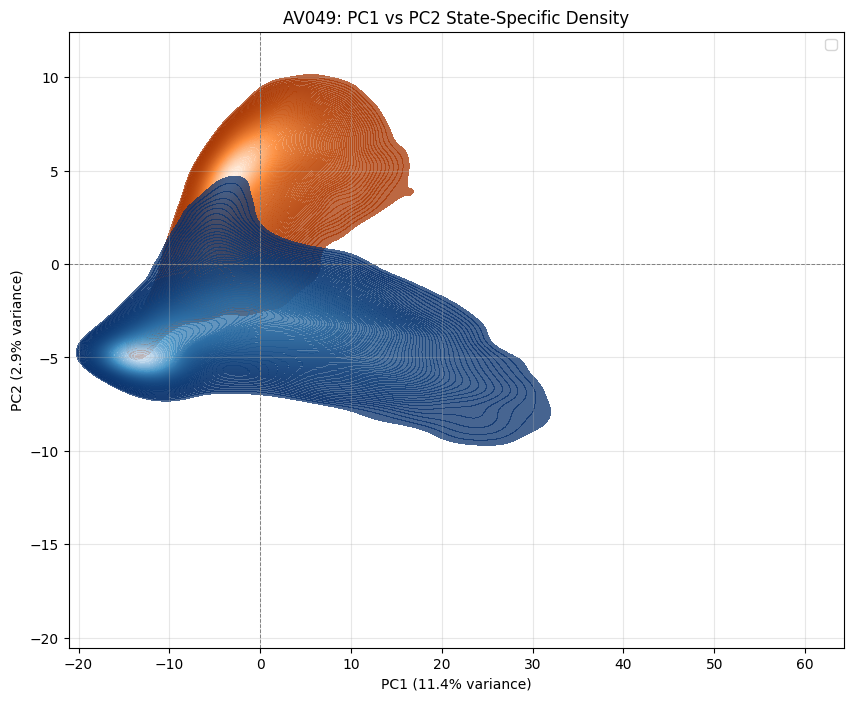

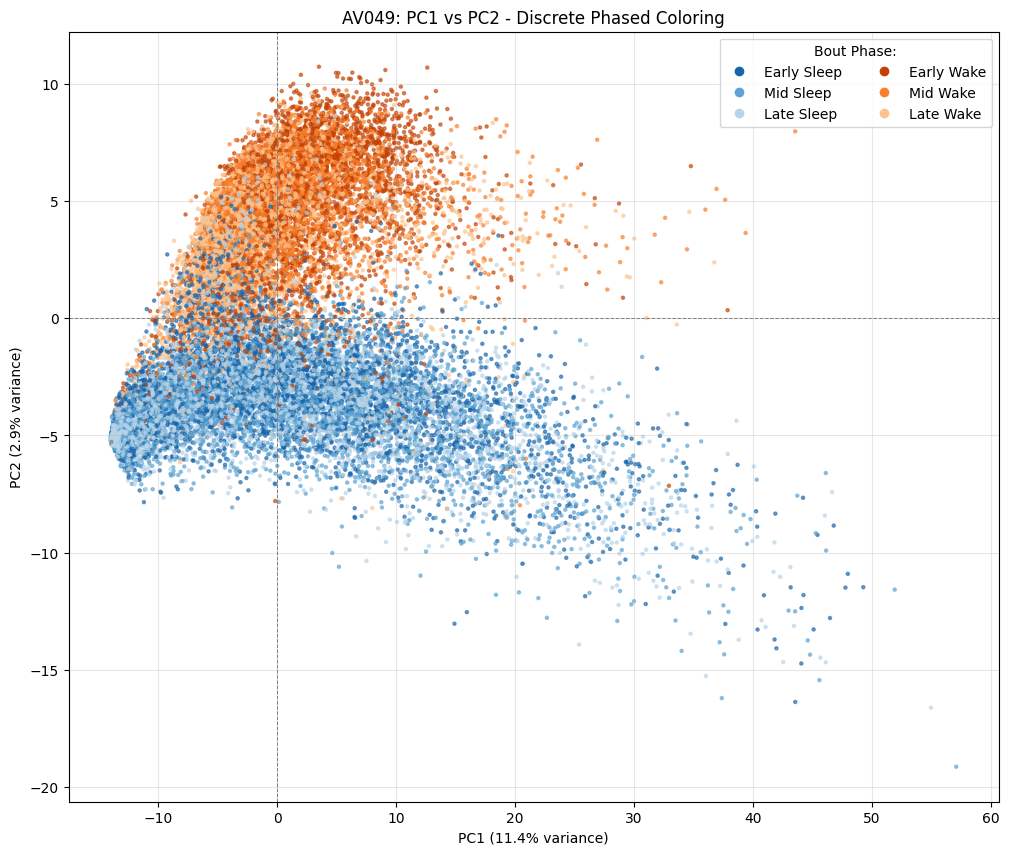

In [109]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.lines import Line2D

# Ensure necessary variables are available
if 'pca_results' in globals() and \
   isinstance(pca_results, dict) and \
   'pca_result' in pca_results and \
   'time_bins_used' in pca_results and \
   'df_neural_sleep' in globals() and \
   'SUBJECT' in globals():

    pc_scores_all = pca_results['pca_result']
    time_bins_pca = pca_results['time_bins_used']
    
    pc1_scores = pc_scores_all[:, 0]
    pc2_scores = pc_scores_all[:, 1]
    
    explained_var_pc1 = pca_results.get("explained_variance_ratio", [0])[0]
    explained_var_pc2 = pca_results.get("explained_variance_ratio", [0,0])[1]

    # --- Prepare bout information (including wake bouts) ---
    all_bouts_list = []
    last_time_point = time_bins_pca[-1] if len(time_bins_pca) > 0 else 0
    current_time = time_bins_pca[0] if len(time_bins_pca) > 0 else 0

    df_neural_sleep_sorted = df_neural_sleep.sort_values(by='start_timestamp_s').reset_index()

    for idx, sleep_bout in df_neural_sleep_sorted.iterrows():
        if sleep_bout['start_timestamp_s'] > current_time:
            all_bouts_list.append({'start': current_time, 'end': sleep_bout['start_timestamp_s'], 'type': 'wake'})
        all_bouts_list.append({'start': sleep_bout['start_timestamp_s'], 'end': sleep_bout['end_timestamp_s'], 'type': 'sleep'})
        current_time = sleep_bout['end_timestamp_s']
    if current_time < last_time_point:
        all_bouts_list.append({'start': current_time, 'end': last_time_point, 'type': 'wake'})
    
    df_all_bouts = pd.DataFrame(all_bouts_list)
            
    pc1_sleep = pc1_scores[sleep_mask]
    pc2_sleep = pc2_scores[sleep_mask]
    pc1_wake = pc1_scores[wake_mask]
    pc2_wake = pc2_scores[wake_mask]

    # --- Custom Colormaps for Plot A ---
    custom_blues_colors = [(0, "#08306b"), (0.5, "#4292c6"), (1, "#c6dbef")] 
    custom_blues_cmap = LinearSegmentedColormap.from_list("custom_blues", custom_blues_colors)
    custom_oranges_colors = [(0, "#a63603"), (0.5, "#fd8d3c"), (1, "#feedde")]
    custom_oranges_cmap = LinearSegmentedColormap.from_list("custom_oranges", custom_oranges_colors)

    # --- Plot A: PC1 vs PC2 Density Plot (State-Specific Colors, White Background) ---
    # Removed dark_background context
    plt.figure(figsize=(10, 8))
    if len(pc1_wake) > 1 and len(pc2_wake) > 1:
        sns.kdeplot(x=pc1_wake, y=pc2_wake, cmap=custom_oranges_cmap, fill=True, thresh=0.05, alpha=0.75, n_levels=100, label="Wake Density")
    if len(pc1_sleep) > 1 and len(pc2_sleep) > 1:
        sns.kdeplot(x=pc1_sleep, y=pc2_sleep, cmap=custom_blues_cmap, fill=True, thresh=0.05, alpha=0.75, n_levels=100, label="Sleep Density")
    
    plt.xlabel(f'PC1 ({explained_var_pc1:.1%} variance)')
    plt.ylabel(f'PC2 ({explained_var_pc2:.1%} variance)')
    plt.title(f'{SUBJECT}: PC1 vs PC2 State-Specific Density')
    plt.grid(True, alpha=0.3) # Grid alpha might be more visible on white
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
    plt.legend()
    plt.show()

    # --- Plot B: PC1 vs PC2 Scatter with Discrete Phased Coloring ---
    plt.figure(figsize=(12, 10))
    
    num_phases = 3 # e.g., Early, Mid, Late. Can increase to 4 if needed.
    phase_labels = ['Early', 'Mid', 'Late'] if num_phases == 3 else ['Early', 'Mid-Early', 'Mid-Late', 'Late'] # Adjust if num_phases changes
    
    # Define distinct colors for each phase
    # Using linspace to pick from the darker to lighter parts of the colormaps
    sleep_phase_palette = ListedColormap(plt.cm.Blues(np.linspace(0.8, 0.3, num_phases)))
    wake_phase_palette = ListedColormap(plt.cm.Oranges(np.linspace(0.8, 0.3, num_phases)))
    
    point_colors_phased = ['gray'] * len(time_bins_pca) # Default for points not in any bout/phase

    for i, t in enumerate(time_bins_pca):
        for _, bout in df_all_bouts.iterrows():
            if bout['start'] <= t < bout['end']:
                bout_duration = bout['end'] - bout['start']
                if bout_duration > 0:
                    relative_pos = (t - bout['start']) / bout_duration
                    phase_index = min(int(relative_pos * num_phases), num_phases - 1) # Determine which phase the point falls into
                    
                    if bout['type'] == 'sleep':
                        point_colors_phased[i] = sleep_phase_palette(phase_index)
                    elif bout['type'] == 'wake':
                        point_colors_phased[i] = wake_phase_palette(phase_index)
                break # Point assigned to a bout

    plt.scatter(pc1_scores, pc2_scores, c=point_colors_phased, s=5, alpha=0.6)

    # Create legend for phased colors
    legend_elements_b = []
    for phase_idx in range(num_phases):
        legend_elements_b.append(Line2D([0], [0], marker='o', color='w', 
                                         label=f'{phase_labels[phase_idx]} Sleep',
                                         markerfacecolor=sleep_phase_palette(phase_idx), markersize=8))
    for phase_idx in range(num_phases):
        legend_elements_b.append(Line2D([0], [0], marker='o', color='w', 
                                         label=f'{phase_labels[phase_idx]} Wake',
                                         markerfacecolor=wake_phase_palette(phase_idx), markersize=8))

    plt.xlabel(f'PC1 ({explained_var_pc1:.1%} variance)')
    plt.ylabel(f'PC2 ({explained_var_pc2:.1%} variance)')
    plt.title(f'{SUBJECT}: PC1 vs PC2 - Discrete Phased Coloring')
    plt.grid(True, alpha=0.3)
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
    if legend_elements_b:
        plt.legend(handles=legend_elements_b, loc='best', title="Bout Phase:", ncol=2) # ncol for better layout if many phases
    plt.show()

else:
    print("Error: Required variables (pca_results, df_neural_sleep, SUBJECT) not found. Please run the PCA analysis cell first.")